In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Conv2D, ReLU, LeakyReLU, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

In [4]:
from keras.datasets import mnist

In [5]:
row = 28
col = 28
planes = 1

img_shape = (row, col , planes)
input_dims = 100

In [6]:
def build_the_generator(input_dims=input_dims, img_shape=img_shape):
    generator = Sequential([
                          Dense(128, input_dim=input_dims), # Input Layer
                          LeakyReLU(alpha=0.01), # f(x) = ax
                          Dense(28 * 28 * 1, activation='tanh'), # Output Layer
                          Reshape(img_shape)
                         ])
    return generator

In [7]:
generator = build_the_generator()

In [8]:
for i, layers_name in enumerate(generator.layers):
    print(i, layers_name)

0 <keras.src.layers.core.dense.Dense object at 0x781282177820>
1 <keras.src.layers.activation.leaky_relu.LeakyReLU object at 0x7812821ac430>
2 <keras.src.layers.core.dense.Dense object at 0x7812821aca00>
3 <keras.src.layers.reshaping.reshape.Reshape object at 0x7812821acb20>


In [9]:
def build_the_discriminator(img_shape=img_shape):
    discriminator = Sequential([
        Flatten(input_shape=img_shape),
        Dense(128),
        LeakyReLU(alpha=0.01),
        Dense(1, activation='sigmoid') # Sigmoid, Since, the discriminator is doing binary classification
    ])
    return discriminator

In [10]:
discriminator=build_the_discriminator()

In [11]:
for i, layers_name in enumerate(discriminator.layers):
    print(i, layers_name)

0 <keras.src.layers.reshaping.flatten.Flatten object at 0x7812821afd00>
1 <keras.src.layers.core.dense.Dense object at 0x7812821af490>
2 <keras.src.layers.activation.leaky_relu.LeakyReLU object at 0x7812821aff10>
3 <keras.src.layers.core.dense.Dense object at 0x781278edccd0>


In [12]:
def gan_model(generator=generator, discriminator=discriminator):
    model_gan = Sequential([
        generator,
        discriminator
    ])
    return model_gan

In [13]:
gan_model = gan_model()

In [14]:
discriminator.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.binary_crossentropy,
                     metrics=['accuracy'])

# Freezing the Model
discriminator.trainable = False

# GAN Compilation
gan_model.compile(loss=tf.keras.losses.binary_crossentropy,
                 optimizer=Adam())

In [15]:
for i , layers in enumerate(gan_model.layers):
    print(f"Layer : {i} - {layers}")
    for j, layers_name in enumerate(layers.layers):
        print(f"\tInner Layer : {j} - {layers_name}")

Layer : 0 - <keras.src.engine.sequential.Sequential object at 0x7812821acfa0>
	Inner Layer : 0 - <keras.src.layers.core.dense.Dense object at 0x781282177820>
	Inner Layer : 1 - <keras.src.layers.activation.leaky_relu.LeakyReLU object at 0x7812821ac430>
	Inner Layer : 2 - <keras.src.layers.core.dense.Dense object at 0x7812821aca00>
	Inner Layer : 3 - <keras.src.layers.reshaping.reshape.Reshape object at 0x7812821acb20>
Layer : 1 - <keras.src.engine.sequential.Sequential object at 0x781278edc820>
	Inner Layer : 0 - <keras.src.layers.reshaping.flatten.Flatten object at 0x7812821afd00>
	Inner Layer : 1 - <keras.src.layers.core.dense.Dense object at 0x7812821af490>
	Inner Layer : 2 - <keras.src.layers.activation.leaky_relu.LeakyReLU object at 0x7812821aff10>
	Inner Layer : 3 - <keras.src.layers.core.dense.Dense object at 0x781278edccd0>


In [16]:
import matplotlib.pyplot as plt
def show_sample_images(generator,rows=4, cols=4):

    z = np.random.normal(0, 1, (rows * cols, input_dims))
    gen_imgs = generator.predict(z, verbose=0)

    # Rescaling the image
    gen_imgs = 2 * gen_imgs -1
    cnt = 0
    plt.figure(figsize=(4,4))
    for row in range(1, rows + 1):
        for col in range(1, cols + 1):
            plt.subplot(rows, cols , cnt + 1)
            temp = gen_imgs[cnt, : , : , 0] / gen_imgs[cnt, : , : , 0].max()
            plt.imshow(temp, cmap='gray')
            plt.axis(False)
            cnt += 1



In [17]:
losses = list()
accuracies = list()
chkps = list()

def train_the_model(epochs , batch_size, checkpoint):
    # Loading the dataset
    (X_train, y_train), (X_val, y_val) = mnist.load_data()

    # Rescaling the dataset
    X_train = X_train / X_train.max()
    X_train = 2 * X_train  - 1 # values between [-1, 1]
    X_train = np.expand_dims(X_train, axis=3) # Flatten the dataset

    # Real image labels
    real_labels = np.ones((batch_size, 1))
    # Fake image labels
    fake_labels = np.zeros((batch_size, 1))

    for iteration in range(1,epochs + 1):
        # Batch of real images
        idx = np.random.randint(0, X_train.shape[0] , batch_size)
        imgs = X_train[idx]

        # Batch of fake images
        z = np.random.normal(0, 1, (batch_size,100))
#         z = tf.expand_dims(z, axis=1) # Flatten Image Matrix
#         print(z.shape)
        gen_imgs = generator.predict(z, verbose=0)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real_labels)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake_labels)
        d_loss, accuracy = 0.5 * np.add(d_loss_fake, d_loss_real)

        # Batch of fake Images for GAN
        z = np.random.normal(0, 1, (batch_size, 100)) # Flatten Image
        gen_imgs = generator.predict(z, verbose=0)

        # GAN loss
        g_loss = gan_model.train_on_batch(z, real_labels)

        if (iteration % checkpoint) == 0:
            losses.append([d_loss, g_loss])
            accuracies.append(100 * accuracy)
            chkps.append(iteration)

            print(f"[ Iteration : {iteration}, Loss : {d_loss}, Accuracy : {accuracy * 100}, GanLoss : {g_loss} ]")
            show_sample_images(generator)


[ Iteration : 1000, Loss : 0.148153780028224, Accuracy : 94.140625, GanLoss : 5.195143222808838 ]
[ Iteration : 2000, Loss : 0.2793089747428894, Accuracy : 88.671875, GanLoss : 4.211694717407227 ]
[ Iteration : 3000, Loss : 0.08450932614505291, Accuracy : 96.09375, GanLoss : 7.191114902496338 ]
[ Iteration : 4000, Loss : 0.10942864790558815, Accuracy : 96.09375, GanLoss : 5.94558048248291 ]
[ Iteration : 5000, Loss : 0.1533619435504079, Accuracy : 94.53125, GanLoss : 5.915256500244141 ]
[ Iteration : 6000, Loss : 0.19282009080052376, Accuracy : 92.1875, GanLoss : 4.796669006347656 ]
[ Iteration : 7000, Loss : 0.20627202093601227, Accuracy : 90.234375, GanLoss : 4.946416854858398 ]
[ Iteration : 8000, Loss : 0.2845844328403473, Accuracy : 88.671875, GanLoss : 4.369537353515625 ]
[ Iteration : 9000, Loss : 0.37223830819129944, Accuracy : 82.421875, GanLoss : 3.0656416416168213 ]
[ Iteration : 10000, Loss : 0.3455447405576706, Accuracy : 82.8125, GanLoss : 3.3193979263305664 ]
[ Iteration

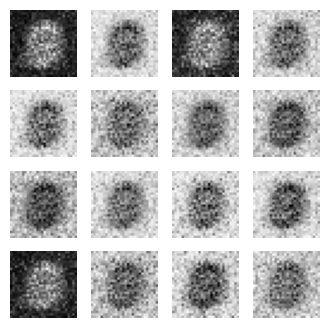

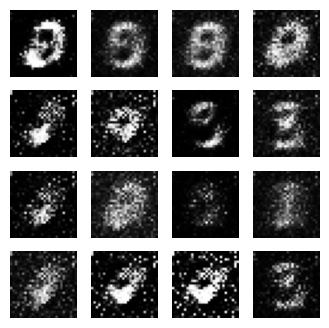

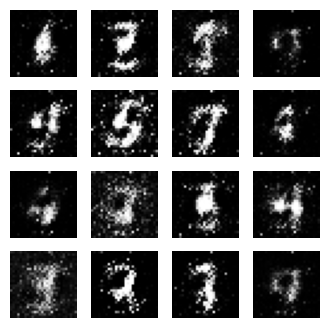

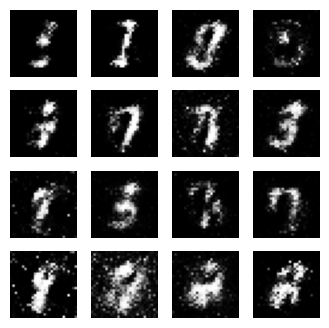

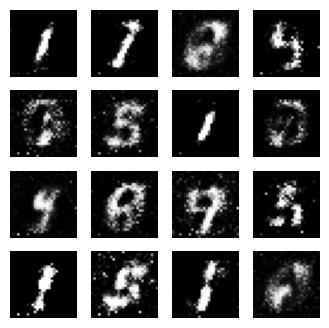

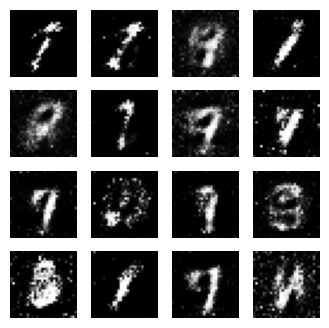

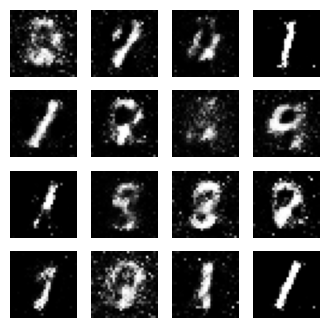

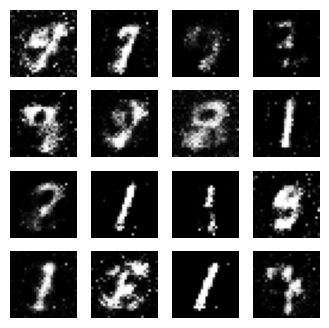

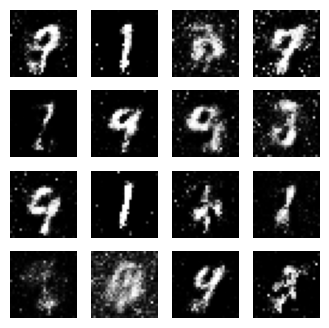

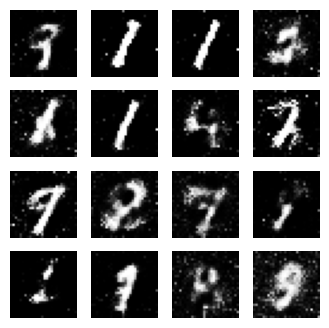

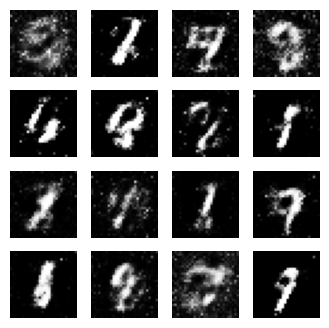

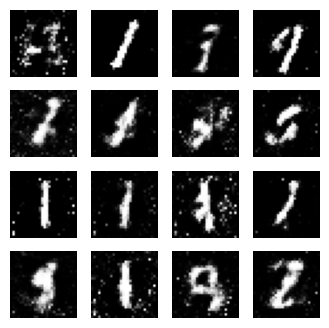

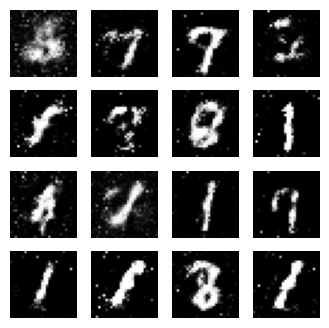

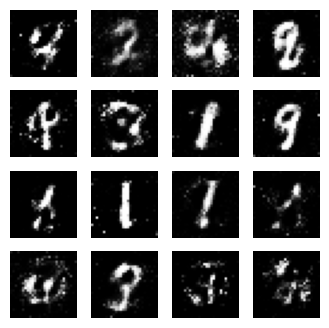

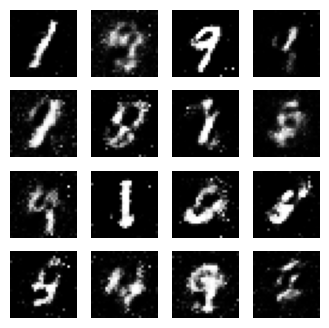

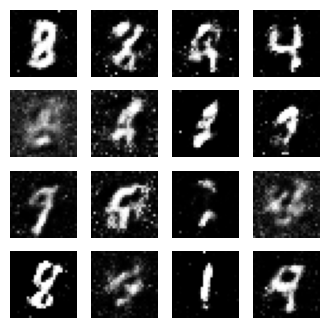

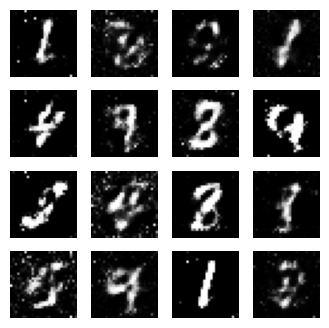

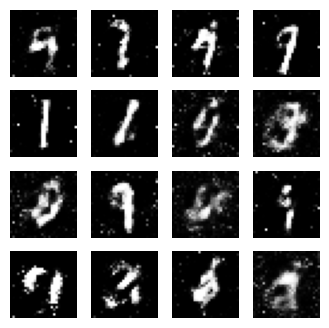

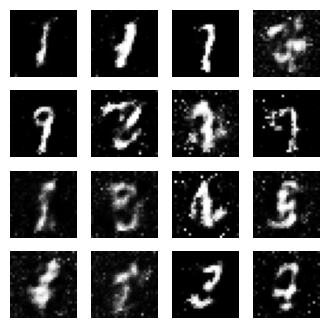

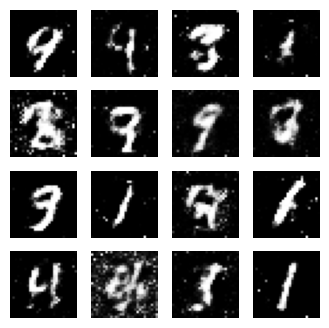

In [18]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train_the_model(iterations, batch_size, sample_interval)
